### Тематическое моделирование 



Построим тематические модели для корпуса новостей Lenta.ru, с которым мы уже работали ранее.

In [56]:
import warnings
warnings.filterwarnings('ignore')
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from corus import load_lenta
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
import re
import numpy as np
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from multiprocess import Pool
import nltk
import pymorphy2
import gensim.models as gm 
from gensim import corpora
import matplotlib.pyplot as plt
%matplotlib inline


In [57]:
path = r'D:\train\lenta/lenta-ru-news.csv.gz'
records = load_lenta(path)
next(records)

LentaRecord(
    url='https://lenta.ru/news/2018/12/14/cancer/',
    title='Названы регионы России с\xa0самой высокой смертностью от\xa0рака',
    text='Вице-премьер по социальным вопросам Татьяна Голикова рассказала, в каких регионах России зафиксирована наиболее высокая смертность от рака, сообщает РИА Новости. По словам Голиковой, чаще всего онкологические заболевания становились причиной смерти в Псковской, Тверской, Тульской и Орловской областях, а также в Севастополе. Вице-премьер напомнила, что главные факторы смертности в России — рак и болезни системы кровообращения. В начале года стало известно, что смертность от онкологических заболеваний среди россиян снизилась впервые за три года. По данным Росстата, в 2017 году от рака умерли 289 тысяч человек. Это на 3,5 процента меньше, чем годом ранее.',
    topic='Россия',
    tags='Общество',
    date=None
)

In [58]:
data = [(record.title, record.topic, record.text, record.tags) for record in records]

In [59]:
data = pd.DataFrame(data, columns=['title','topic','text','tags'])

In [60]:
data.sample(3)

,title,topic,text,tags
526663,"Тимошенко реанимирует программу ""Контрабанда — стоп""",Бывший СССР,"Премьер-министр Украины Юлия Тимошенко возобновит действие программы ""Контрабанда - стоп"", направленной на борьбу с коррупцией, прежде всего в рядах таможенников. Об этом, как передает ProUA, заявила сама глава правительства, открывая в среду заседание кабинета министров. По мнению Тимошенко, реализация указанной программы позволит таможенной службе работать более качественно. Государственная программа ""Контрабанда - стоп"" была утверждена еще при первом премьерстве Тимошенко в марте 2005 года. Однако в ноябре 2006 кабинет министров Виктора Януковича поручил Министерству экономики рассмотреть целесообразность продления этой программы, принятой на 2005-2006, на последующий период. В результате программа оказалась фактически свернутой. В конце прошлого года особое внимание на деятельность таможенников обратил президент Украины Виктор Ющенко. После выговора, который глава государства сделал руководству Гостаможни, в этой структуре прошли кадровые чистки. Проверками деятельности таможенников занялась также Служба безопасности Украины.",Все
468901,Израильские археологи нашли древнюю керамику,Культура,"Археологи Израильского управления древностей (Israel Antiquities Authority) при раскопках в южном Иерусалиме обнаружили остатки здания, внутри которого находились керамические изделия, относящиеся к концу VIII века до нашей эры, а также к более позднему периоду, сообщает ""Гаарец"". Постройка представляет собой несколько помещений, окружающих внутренний двор. На территории двора найдены гончарная печь и остатки керамической посуды. По мнению археологов, здание было разрушено во время захвата Иерусалима в 586 году вавилонянами, которые тогда же уничтожили и первый Иерусалимский храм. Позднее место снова было обжито евреями, однако в 70 году нашей эры опять опустошено - на этот раз римской армией в ходе первой Иудейской войны. На некоторых уцелевших изделиях, а также на фрагментах керамики найдены царские клейма иудейского царя Езекии (Hezekiah), правившего на рубеже VIII - VII веков до нашей эры. Четыре таких клейма поставлены на ручках больших сосудов для хранения вина и масла. Встречаются также и клейма двух высокопоставленных чиновников - Агимелеха бен Амадиаху (Ahimelekh ben Amadyahu) и Иегохила бен Шахара (Yehokhil ben Shahar). Одно из клейм Иегохила проставлено поверх царского клейма. Ценной находкой стал фрагмент горловины сосуда с надписью на древнееврейском, сделанной, предположительно, во II - I веках до нашей эры. В 2006 году израильскими археологами были обнаружены остатки монастыря, относящиеся к тому же периоду, что и найденные постройки. По мнению ученых, последние открытия подтверждают гипотезу, что эта территория является ""Метофой"" - местом, упоминаемом отцами церкви в своих сочинениях Византийского периода (VI - XV века нашей эры).",Все
735084,Актер Владимир Стеклов станет космонавтом,Россия,"Московский актер Владимир Стеклов готовится к участию в 28-й экспедиции на орбитальную станцию ""Мир"", сообщает РИА ""Новости"". Экспедиция состоится в конце марта-начале апреля текущего года. Стеклов, вероятно, будет третьим членом экипажа наряду с космонавтами Сергеем Залетиным и Александром Калери. Первый в истории России полет профессионального актера в космос связан со съемками художественного фильма и может продлиться более месяца. По словам Стеклова, герой киноленты ""встретится с обстоятельствами, которые поставят его перед моральным выбором, как это часто бывает в жизни"".",Все


In [61]:
len(data)

739350

In [62]:
data.topic.nunique()

24

In [63]:
data.topic.value_counts()

Россия               160518
Мир                  136680
Экономика            79538 
Спорт                64421 
Культура             53803 
Бывший СССР          53402 
Наука и техника      53136 
Интернет и СМИ       44675 
Из жизни             27611 
Дом                  21734 
Силовые структуры    19596 
Ценности             7766  
Бизнес               7399  
Путешествия          6408  
69-я параллель       1268  
Крым                 666   
Культпросвет         340   
                     203   
Легпром              114   
Библиотека           65    
Оружие               3     
ЧМ-2014              2     
МедНовости           1     
Сочи                 1     
Name: topic, dtype: int64

In [64]:
data.tags.nunique()

89

In [65]:
data.tags.value_counts()

Все              453763
Политика         33220 
Общество         27559 
                 26514 
Украина          17934 
                 ...   
Страноведение    21    
Выборы           11    
Мировой опыт     6     
Вооружение       3     
Инновации        1     
Name: tags, Length: 89, dtype: int64

### Предобработка


Все модели, с которыми мы будем работать далее, работают с предобработанными текстами, поэтому сперва проведем стандартную предобработку текста:

In [67]:

# nltk.download('stopwords')

In [68]:
stopwords_list = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()

In [69]:
def preprocess(text,regex = words_regex,lemmer = morph, stopwords = stopwords_list):
    tokens =  regex.findall(text.lower())
    tokens =  [w for w in tokens if w.isalpha() and len(w) >= 3]
    answer = []
    for w in tokens:    
        lemmas = lemmer.parse(w)[0].normal_form
        if not lemmas.isalpha() or lemmas in stopwords :
            continue
        answer.append(lemmas)
    return answer
    


In [70]:
data.text.iloc[1]

'Сотрудники социальной сети Instagram проанализировали поставленные пользователями смайлики, геолокации и хештеги и опубликовали итоги 2018 года. Об этом сообщается на официальном сайте Instagram. Таким образом, самой счастливой геолокацией Instagram признал Диснейленд в Токио, так как больше всего счастливых смайликов в 2018 году пользователи ставили именно под фотографиями из японского Диснейленда. Также эксперты назвали самый популярный фильтр для лица: им стал фильтр с сердечками на глазах. А, например, самыми часто используемыми хештегами в 2018 году были #metoo, #timesup и #marchforourlives. В ноябре сотрудники британской ассоциации потребителей Which? составили рейтинг самых безопасных стран для путешествий. Специалисты проанализировали 20 самых популярных туристических направлений по четырем критериям: уровень преступности, угроза здоровью, вероятность теракта и стихийных бедствий. Самой безопасной страной по всем параметрам стала Исландия.'

In [71]:
print(preprocess(data.text.iloc[1]))

['сотрудник', 'социальный', 'сеть', 'instagram', 'проанализировать', 'поставить', 'пользователь', 'смайлик', 'геолокация', 'хештег', 'опубликовать', 'итог', 'год', 'это', 'сообщаться', 'официальный', 'сайт', 'instagram', 'образ', 'счастливый', 'геолокация', 'instagram', 'признать', 'диснейленд', 'токио', 'большой', 'весь', 'счастливый', 'смайлик', 'год', 'пользователь', 'ставить', 'именно', 'фотография', 'японский', 'диснейленд', 'также', 'эксперт', 'назвать', 'самый', 'популярный', 'фильтр', 'лицо', 'стать', 'фильтр', 'сердечко', 'глаз', 'например', 'самый', 'часто', 'использовать', 'хештег', 'год', 'metoo', 'timesup', 'marchforourlives', 'ноябрь', 'сотрудник', 'британский', 'ассоциация', 'потребитель', 'which', 'составить', 'рейтинг', 'самый', 'безопасный', 'страна', 'путешествие', 'специалист', 'проанализировать', 'самый', 'популярный', 'туристический', 'направление', 'четыре', 'критерий', 'уровень', 'преступность', 'угроза', 'здоровье', 'вероятность', 'теракт', 'стихийный', 'бедств

Ниже мы оставим только случайные 10,000 текстов из нашей коллекции, чтобы ускорить вычисления:

In [73]:
%%time
with Pool(15) as p:
    preprocessed_text = list(tqdm(p.imap(preprocess, data['text']),total = len(data)))


Wall time: 3h 41min 8s


In [74]:
data['preprocessed_text'] = preprocessed_text
data.sample(3)

,title,topic,text,tags,preprocessed_text
25426,"«Башнефть» направит на выплату дивидендов 28,2 миллиарда рублей",Экономика,"Совет директоров «Башнефти» принял решение рекомендовать общему собранию акционеров компании выплатить дивиденды по итогам 2017 года в объеме 28,2 миллиарда рублей. С учетом дивидендов по итогам 9 месяцев 2017 года общий объем выплат акционерам превысит 38 процентов от чистой прибыли по МСФО за 2017 год (при этом дивидендная политика компании предусматривает выплаты на уровне 25 процентов от чистой прибыли по МСФО). Об этом сообщили «Ленте.ру» в «Башнефти». В компании отметили, что значительный объем выплат обусловлен сильными финансовыми показателями, которые «Башнефть» продемонстрировала в первом квартале 2018 года: рост чистой прибыли по сравнению с первым кварталом 2017 года на 64,4 процента, до 14 миллиардов рублей. При этом динамика роста чистой прибыли многократно опередила обусловленный благоприятной конъюнктурой рынка нефти рост выручки по сравнению с аналогичным периодом прошлого года — на 14,1 процента, до 179,3 миллиарда рублей. В «Башнефти» также подчеркивают, что чистая прибыль компании увеличилась, несмотря на действовавшие ограничения по объему добычи в рамках соглашения «ОПЕК+», а также негативное влияние на EBITDA ряда других макроэкономических факторов, находящихся вне управления менеджмента, в частности, укрепления курса рубля и временного разрыва между увеличением цены закупаемого сырья и ростом экспортных цен на нефтепродукты и нефтехимию. По мнению директора аналитического департамента компании «Альпари» Анны Кокоревой, смена контролирующего акционера и полная замена топ-менеджмента благотворно повлияла на работу «Башнефти». «Компания показала сильные финансовые результаты в первом квартале 2018 года, увеличив чистую прибыль на 64,4 процента по сравнению с аналогичным показателем предыдущего года, а операционный денежный поток почти в три раза (до 50,8 миллиарда рублей)», — говорит аналитик. Кроме того, компания сообщает о том, что сегодня стало известно, что «Bashneft International B.V.» по результатам бурения первой поисковой скважины на Блоке 12 в республике Ирак открыла новое месторождение нефти, получившее название «Салман». Это первый зарубежный проект компании. К выходу на международный рынок «Башнефть» стремилась не один год. Ирак является чрезвычайно перспективным регионом с точки зрения добычи углеводородов и одним из лидеров по запасам (около 19,3 миллиардов тонн нефти). Комментирую данное событие, Кокорева высказала мнение, что в текущих условиях постоянного повышения конкурентной борьбы наибольшие шансы на успех и стабильное развитие будут иметь компании с наиболее качественной ресурсной базой. »Выйдя на международный рынок, ""Башнефть"" создает хороший задел для будущего роста», — считает она.",Бизнес,"[совет, директор, башнефть, принять, решение, рекомендовать, общий, собрание, акционер, компания, выплатить, дивиденд, итог, год, объём, миллиард, рубль, учёт, дивиденд, итог, месяц, год, общий, объём, выплата, акционер, превысить, процент, чистый, прибыль, мсфо, год, это, дивидендный, политика, компания, предусматривать, выплата, уровень, процент, чистый, прибыль, мсфо, это, сообщить, лента, башнефть, компания, отметить, значительный, объём, выплата, обусловить, сильный, финансовый, показатель, который, башнефть, продемонстрировать, первый, квартал, год, рост, чистый, прибыль, сравнение, первый, квартал, год, процент, миллиард, рубль, это, динамика, рост, чистый, прибыль, многократно, опередить, обусловить, благоприятный, конъюнктура, рынок, нефть, рост, выручка, сравнение, аналогичный, период, прошлое, год, процент, миллиард, рубль, башнефть, также, подчёркивать, чистый, прибыль, компания, ...]"
379375,"Фаворитом премии британской киноакадемии стал ""Король говорит!""",Культура,"18 января в Лондоне были объявлены фильмы-номинанты на премию Британской академии кино и телевидения (BAFTA). Полный список претендентов на награду можно посмотреть на официальном сайте организ

In [84]:
p =r'D:\train\lenta/data.csv'
p_d=r'D:\train\lenta/lenta.dict'
p_m = r'D:\train\lenta/lenta.model'

In [76]:
data.to_csv(p,index=False)

In [ ]:
# data = pd.read_csv(p)

## Модель LDA


Первая модель, которую мы рассмотрим, LDA - латентное размещение Дирихле. Воспользуемся реализацией из библиотеки gensim.

In [77]:
import gensim.models as gm 
from gensim import corpora

Модель использует векторное представление документов, например, мешок слов (bow), поэтому сперва создадим словарь:

In [80]:
%%time
dictionary = corpora.Dictionary(data['preprocessed_text'])

dictionary.filter_extremes(no_below = 15, no_above = 0.8) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save(p_d)

Wall time: 1min 26s


Векторизуем документы:

In [86]:
len(dictionary)

78314

In [85]:
%%time
corpus = [dictionary.doc2bow(text) for text in data['preprocessed_text']]
corpora.MmCorpus.serialize(p_m, corpus) 

Wall time: 1min 58s


In [90]:
len(corpus)

739350

Теперь можем обучать модель:

In [91]:
%%time 
lda = gm.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=15, chunksize=10000, update_every=1, passes=4)

Wall time: 0 ns


Посмотрим на получившиеся темы:

In [92]:
lda.show_topics(num_topics=15, num_words=20, formatted=True)

[(0,
  '0.025*"год" + 0.024*"процент" + 0.019*"доллар" + 0.018*"компания" + 0.013*"миллиард" + 0.011*"банк" + 0.010*"это" + 0.010*"рубль" + 0.010*"миллион" + 0.009*"россия" + 0.009*"акция" + 0.007*"российский" + 0.007*"рынок" + 0.007*"цена" + 0.006*"нефть" + 0.006*"составить" + 0.006*"который" + 0.005*"газпром" + 0.004*"финансовый" + 0.004*"сообщать"'),
 (1,
  '0.027*"доллар" + 0.025*"миллион" + 0.020*"компания" + 0.019*"год" + 0.017*"тысяча" + 0.010*"продажа" + 0.009*"который" + 0.007*"место" + 0.006*"сообщать" + 0.006*"самый" + 0.006*"продать" + 0.006*"фунт" + 0.006*"это" + 0.005*"около" + 0.005*"стоимость" + 0.005*"автомобиль" + 0.005*"крупный" + 0.005*"аукцион" + 0.005*"также" + 0.005*"магазин"'),
 (2,
  '0.024*"суд" + 0.021*"дело" + 0.016*"год" + 0.010*"который" + 0.008*"уголовный" + 0.007*"обвинение" + 0.007*"это" + 0.007*"прокуратура" + 0.007*"адвокат" + 0.006*"задержать" + 0.006*"убийство" + 0.006*"бывший" + 0.006*"преступление" + 0.005*"следствие" + 0.005*"сотрудник" + 0.005*"

Почимстим еще слова

In [95]:
%%time
new_stop_words=["это",'составить','который','сообщать','около','бывший','также','свой','представитель','сообщать','город',
               'год','мочь','слово','the',"имя" ,"весь",'стать','около']
data.preprocessed_text = data.preprocessed_text.apply(lambda x: [i for i in x if i not in new_stop_words])

dictionary = corpora.Dictionary(data['preprocessed_text'])
dictionary.filter_extremes(no_below = 15, no_above = 0.8) 
dictionary.save(p_d)

corpus = [dictionary.doc2bow(text) for text in data['preprocessed_text']]
corpora.MmCorpus.serialize(p_m, corpus) 

Wall time: 3min 42s


In [96]:
%%time 
lda = gm.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=15, chunksize=10000, update_every=1, passes=4)
lda.show_topics(num_topics=15, num_words=20, formatted=True)

Wall time: 19min 58s


[(0,
  '0.023*"фильм" + 0.014*"интернет" + 0.013*"сайт" + 0.008*"компания" + 0.008*"новый" + 0.008*"режиссёр" + 0.007*"роль" + 0.006*"пользователь" + 0.005*"главный" + 0.005*"первый" + 0.005*"сеть" + 0.005*"картина" + 0.005*"канал" + 0.005*"программа" + 0.005*"игра" + 0.005*"проект" + 0.004*"актёр" + 0.004*"телеканал" + 0.004*"информация" + 0.004*"com"'),
 (1,
  '0.013*"хороший" + 0.011*"премия" + 0.009*"группа" + 0.009*"место" + 0.009*"мир" + 0.008*"первый" + 0.008*"получить" + 0.008*"фестиваль" + 0.007*"олимпийский" + 0.007*"театр" + 0.007*"российский" + 0.007*"награда" + 0.006*"конкурс" + 0.006*"касьянов" + 0.006*"церемония" + 0.005*"золотой" + 0.005*"участие" + 0.005*"концерт" + 0.005*"песня" + 0.005*"приз"'),
 (2,
  '0.025*"суд" + 0.022*"дело" + 0.009*"уголовный" + 0.008*"обвинение" + 0.008*"задержать" + 0.007*"прокуратура" + 0.007*"адвокат" + 0.007*"убийство" + 0.006*"преступление" + 0.006*"сотрудник" + 0.006*"следствие" + 0.005*"решение" + 0.005*"судебный" + 0.005*"расследование

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline

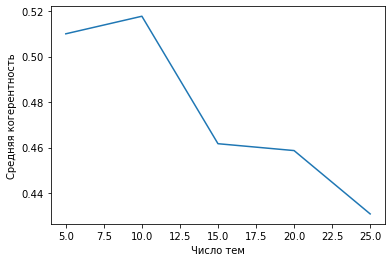

Wall time: 4h 24min


In [100]:
%%time
topics_list = [5, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = gm.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num,\
                            chunksize=50, update_every=1, passes=2)
    coherences.append(gm.CoherenceModel(model=lda, texts=data['preprocessed_text'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

еще раз подчистим и изменим кол тем на 10

In [101]:
%%time
new_stop_words_2=["россия","первый","российский","место","всё","com"]
data.preprocessed_text = data.preprocessed_text.apply(lambda x: [i for i in x if i not in new_stop_words_2])
data.to_csv(p,index=False)
dictionary = corpora.Dictionary(data['preprocessed_text'])
dictionary.filter_extremes(no_below = 15, no_above = 0.8) 
dictionary.save(p_d)

corpus = [dictionary.doc2bow(text) for text in data['preprocessed_text']]
corpora.MmCorpus.serialize(p_m, corpus)

Wall time: 3min 34s


In [102]:
data.to_csv(p,index=False)

In [116]:
%%time 
lda = gm.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, chunksize=10000, update_every=1, passes=4)
lda.show_topics(num_topics=10, num_words=20, formatted=True)

Wall time: 19min 27s


[(0,
  '0.021*"военный" + 0.011*"самолёт" + 0.008*"ракета" + 0.007*"новый" + 0.007*"система" + 0.007*"вертолёт" + 0.007*"оборона" + 0.006*"время" + 0.006*"корабль" + 0.006*"сила" + 0.005*"космический" + 0.005*"войско" + 0.005*"база" + 0.005*"полёт" + 0.005*"боевой" + 0.005*"ввс" + 0.004*"морской" + 0.004*"американский" + 0.004*"сша" + 0.004*"вооружение"'),
 (1,
  '0.024*"компания" + 0.014*"доллар" + 0.010*"миллиард" + 0.010*"миллион" + 0.009*"банк" + 0.008*"акция" + 0.007*"процент" + 0.006*"правительство" + 0.006*"рубль" + 0.005*"сумма" + 0.005*"средство" + 0.005*"финансовый" + 0.004*"крупный" + 0.004*"предприятие" + 0.004*"заявить" + 0.004*"рынок" + 0.004*"бюджет" + 0.004*"газпром" + 0.004*"директор" + 0.004*"газета"'),
 (2,
  '0.017*"суд" + 0.012*"дело" + 0.007*"решение" + 0.006*"заявить" + 0.005*"выборы" + 0.005*"закон" + 0.005*"глава" + 0.004*"депутат" + 0.004*"адвокат" + 0.004*"москва" + 0.004*"право" + 0.004*"газета" + 0.004*"обвинение" + 0.004*"президент" + 0.004*"партия" + 0.00

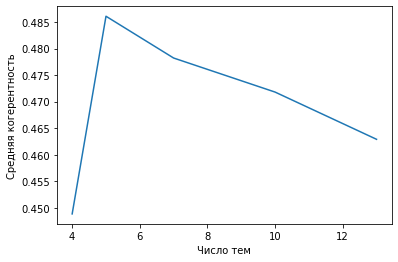

Wall time: 2h 39min 50s


In [105]:
%%time
topics_list = [4, 5, 7, 10, 13]
coherences = []

for num in tqdm(topics_list):
    lda = gm.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num,\
                            chunksize=50, update_every=1, passes=2)
    coherences.append(gm.CoherenceModel(model=lda, texts=data['preprocessed_text'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

Посмотрим результаты 10 тем

In [117]:
%%time
print('10 тем')
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

print('Средняя когерентность: ',\
      gm.CoherenceModel(model=lda, texts=data['preprocessed_text'], dictionary=dictionary, coherence='c_v').get_coherence())

10 тем
Персплексия:  0.00017589911679441255
Средняя когерентность:  0.5923420942380178
Wall time: 8min 2s


Посмотрим результат на 5 тем


In [118]:
%%time 
lda = gm.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=5, chunksize=10000, update_every=1, passes=4)
lda.show_topics(num_topics=5, num_words=20, formatted=True)

Wall time: 17min 21s


[(0,
  '0.007*"фильм" + 0.005*"новый" + 0.004*"время" + 0.004*"сайт" + 0.004*"интернет" + 0.003*"американский" + 0.003*"человек" + 0.003*"компания" + 0.003*"работа" + 0.003*"сша" + 0.003*"получить" + 0.003*"однако" + 0.003*"самый" + 0.003*"британский" + 0.003*"известный" + 0.002*"миллион" + 0.002*"режиссёр" + 0.002*"тысяча" + 0.002*"роль" + 0.002*"картина"'),
 (1,
  '0.014*"матч" + 0.013*"команда" + 0.009*"сборная" + 0.007*"клуб" + 0.007*"счёт" + 0.007*"чемпионат" + 0.006*"мир" + 0.006*"второй" + 0.006*"игра" + 0.005*"победа" + 0.005*"турнир" + 0.005*"минута" + 0.004*"чемпион" + 0.004*"время" + 0.004*"третий" + 0.003*"выиграть" + 0.003*"сезон" + 0.003*"последний" + 0.003*"хороший" + 0.003*"тренер"'),
 (2,
  '0.016*"компания" + 0.013*"доллар" + 0.013*"процент" + 0.009*"миллион" + 0.007*"миллиард" + 0.006*"рубль" + 0.005*"банк" + 0.005*"тысяча" + 0.005*"акция" + 0.005*"рынок" + 0.004*"цена" + 0.004*"новый" + 0.003*"сумма" + 0.003*"система" + 0.003*"время" + 0.003*"нефть" + 0.003*"сша" + 

In [119]:
%%time
print('5 тем')
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

print('Средняя когерентность: ',\
      gm.CoherenceModel(model=lda, texts=data['preprocessed_text'], dictionary=dictionary, coherence='c_v').get_coherence())

5 тем
Персплексия:  0.00021065140952300666
Средняя когерентность:  0.5397911623879411
Wall time: 7min 13s


In [111]:
# Посмотрим результат на 6 тем

In [120]:

%%time 
lda = gm.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=6, chunksize=10000, update_every=1, passes=4)
lda.show_topics(num_topics=6, num_words=20, formatted=True)

Wall time: 17min 30s


[(0,
  '0.010*"человек" + 0.008*"дело" + 0.008*"суд" + 0.006*"сообщить" + 0.006*"москва" + 0.005*"новость" + 0.005*"находиться" + 0.005*"время" + 0.005*"риа" + 0.005*"погибнуть" + 0.005*"сотрудник" + 0.005*"задержать" + 0.005*"результат" + 0.004*"район" + 0.004*"данные" + 0.004*"произойти" + 0.004*"взрыв" + 0.004*"полиция" + 0.004*"дом" + 0.004*"служба"'),
 (1,
  '0.015*"матч" + 0.013*"команда" + 0.009*"сборная" + 0.008*"счёт" + 0.008*"клуб" + 0.008*"чемпионат" + 0.007*"мир" + 0.006*"второй" + 0.006*"игра" + 0.006*"победа" + 0.006*"юкос" + 0.005*"турнир" + 0.005*"минута" + 0.005*"чемпион" + 0.004*"время" + 0.004*"третий" + 0.004*"выиграть" + 0.004*"тренер" + 0.004*"очко" + 0.004*"игрок"'),
 (2,
  '0.008*"фильм" + 0.005*"сайт" + 0.004*"новый" + 0.004*"интернет" + 0.004*"время" + 0.003*"человек" + 0.003*"американский" + 0.003*"известный" + 0.003*"получить" + 0.003*"британский" + 0.003*"хороший" + 0.003*"режиссёр" + 0.003*"работа" + 0.003*"самый" + 0.003*"роль" + 0.002*"картина" + 0.002*"

In [121]:
%%time
print('6 тем')
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

print('Средняя когерентность: ',\
      gm.CoherenceModel(model=lda, texts=data['preprocessed_text'], dictionary=dictionary, coherence='c_v').get_coherence())

6 тем
Персплексия:  0.00021420367195454135
Средняя когерентность:  0.5402596750339438
Wall time: 7min 19s


На мой взгляд, следует оставить 10 тем.

In [122]:
%%time
new_stop_words_3=["время","вопрос","главный","однако"]
data.preprocessed_text = data.preprocessed_text.apply(lambda x: [i for i in x if i not in new_stop_words_3])
data.to_csv(p,index=False)
dictionary = corpora.Dictionary(data['preprocessed_text'])
dictionary.filter_extremes(no_below = 15, no_above = 0.8) 
dictionary.save(p_d)

corpus = [dictionary.doc2bow(text) for text in data['preprocessed_text']]
corpora.MmCorpus.serialize(p_m, corpus)

Wall time: 4min 27s


In [123]:
%%time 
lda = gm.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, chunksize=10000, update_every=1, passes=4)
lda.show_topics(num_topics=10, num_words=20, formatted=True)

Wall time: 18min 53s


[(0,
  '0.014*"человек" + 0.009*"произойти" + 0.009*"находиться" + 0.009*"погибнуть" + 0.008*"результат" + 0.008*"взрыв" + 0.007*"район" + 0.007*"сообщить" + 0.007*"пострадать" + 0.007*"новость" + 0.006*"риа" + 0.006*"самолёт" + 0.006*"дом" + 0.006*"данные" + 0.006*"москва" + 0.005*"здание" + 0.004*"автомобиль" + 0.004*"служба" + 0.004*"машина" + 0.004*"причина"'),
 (1,
  '0.023*"военный" + 0.013*"боевик" + 0.010*"ирак" + 0.009*"аль" + 0.009*"израильский" + 0.009*"террорист" + 0.008*"войско" + 0.008*"сила" + 0.008*"американский" + 0.007*"операция" + 0.007*"армия" + 0.006*"теракт" + 0.006*"военнослужащий" + 0.006*"оборона" + 0.006*"иракский" + 0.006*"самолёт" + 0.006*"оружие" + 0.005*"сша" + 0.005*"территория" + 0.005*"солдат"'),
 (2,
  '0.017*"матч" + 0.015*"команда" + 0.011*"сборная" + 0.009*"клуб" + 0.009*"чемпионат" + 0.009*"счёт" + 0.007*"мир" + 0.007*"игра" + 0.007*"второй" + 0.006*"победа" + 0.006*"турнир" + 0.006*"минута" + 0.006*"чемпион" + 0.004*"выиграть" + 0.004*"игрок" + 0.

Посмотрим на метрики качества получившейся модели: перплексию и среднюю когерентность:

In [125]:
%%time
print('10 тем')
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

print('Средняя когерентность: ',\
      gm.CoherenceModel(model=lda, texts=data['preprocessed_text'], dictionary=dictionary, coherence='c_v').get_coherence())

10 тем
Персплексия:  0.00017496770178061116
Средняя когерентность:  0.6093336427179861
Wall time: 7min 58s


In [128]:
lda.save(r'D:\train\lenta/lda.model')

In [143]:
# Интерпритация тем
my_topic = ['Проишествия','Военные','Спорт',"Внутренняя политика","Финансы","Технологии","Протестные акции", "Международная политика",
           "Правоохранительная деятельность","Искуство"]


In [141]:
data['tema']=lda.get_document_topics(corpus)

In [146]:
def get_topics(data):
    data = data[:3]
    data.sort(key= lambda x:x[1],reverse = True)
    return [my_topic[i[0]] for i in data]

In [149]:
data.tema = data.tema.apply(get_topics)

In [150]:
data

,title,topic,text,tags,preprocessed_text,tema
0,Австрия не представила доказательств вины российских биатлонистов,Спорт,"Австрийские правоохранительные органы не представили доказательств нарушения российскими биатлонистами антидопинговых правил. Об этом сообщил посол России в Вене Дмитрий Любинский по итогам встречи уполномоченного адвоката дипмиссии с представителями прокуратуры страны, передает ТАСС. «Действует презумпция невиновности. Каких-либо ограничений свободы передвижения для команды нет», — добавили в посольстве. Международный союз биатлонистов (IBU) также не будет применять санкции к российским биатлонистам. Все они продолжат выступление на Кубке мира. Полиция нагрянула в отель сборной России в Хохфильцене вечером 12 декабря. Как написал биатлонист Александр Логинов, их считают виновными в махинациях с переливанием крови. Биатлонисту Антону Шипулину, также попавшему в список, полиция нанесла отдельный визит: сейчас он тренируется отдельно в австрийском Обертиллахе. Обвинения спортсмен назвал бредом, а также указал на «охоту на ведьм» в мировом биатлоне. В Австрии прием допинга — уголовное преступление. Максимальное наказание за его употребление — три года тюрьмы.",Зимние виды,"[австрийский, правоохранительный, орган, представить, доказательство, нарушение, биатлонист, антидопинговый, правило, сообщить, посол, вена, дмитрий, любинский, итог, встреча, уполномоченный, адвокат, дипмиссия, прокуратура, страна, передавать, тасс, действовать, презумпция, невиновность, либо, ограничение, свобода, передвижение, команда, добавить, посольство, международный, союз, биатлонист, ibu, применять, санкция, биатлонист, продолжить, выступление, кубок, мир, полиция, нагрянуть, отель, сборная, хохфильцен, вечером, декабрь, написать, биатлонист, александр, логинов, считать, виновный, махинация, переливание, кровь, биатлонист, антон, шипулина, попасть, список, полиция, нанести, отдельный, визит, тренироваться, отдельно, австрийский, обертиллах, обвинение, спортсмен, назвать, бред, указать, охота, ведьма, мировой, биатлон, австрия, приём, допинг, уголовный, преступление, максимальный, наказание, употребление, тюрьма]","[Правоохранительная деятельность, Спорт, Международная политика]"
1,Обнаружено самое счастливое место на планете,Путешествия,"Сотрудники социальной сети Instagram проанализировали поставленные пользователями смайлики, геолокации и хештеги и опубликовали итоги 2018 года. Об этом сообщается на официальном сайте Instagram. Таким образом, самой счастливой геолокацией Instagram признал Диснейленд в Токио, так как больше всего счастливых смайликов в 2018 году пользователи ставили именно под фотографиями из японского Диснейленда. Также эксперты назвали самый популярный фильтр для лица: им стал фильтр с сердечками на глазах. А, например, самыми часто используемыми хештегами в 2018 году были #metoo, #timesup и #marchforourlives. В ноябре сотрудники британской ассоциации потребителей Which? составили рейтинг самых безопасных стран для путешествий. Специалисты проанализировали 20 самых популярных туристических направлений по четырем критериям: уровень преступности, угроза здоровью, вероятность теракта и стихийных бедствий. Самой безопасной страной по всем параметрам стала Исландия.",Мир,"[сотрудник, социальный, сеть, instagram, проанализировать, поставить, пользователь, смайлик, геолокация, хештег, опубликовать, итог, сообщаться, официальный, сайт, instagram, образ, счастливый, геолокация, instagram, признать, диснейленд, токио, большой, счастливый, смайлик, пользователь, ставить, именно, фотография, японский, диснейленд, эксперт, назвать, самый, популярный, фильтр, лицо, фильтр, сердечко, глаз, например, самый, часто, использовать, хештег, metoo, timesup, marchforourlives, ноябрь, сотрудник, британский, ассоциация, потребитель, which, рейтинг, самый, безопасный, страна, путешествие, специалист, проанализировать, самый, популярный, туристический, направление, четыре, критерий, уровень, преступность, угроза, здоровье, вероятность, тера

In [151]:
data.to_csv(p,index=False)

На полученные темы можно посмотреть, изобразив их на плоскости с помощью библиотеки pyLDAvis. Чтобы спроецировать темы на плоскость, внутри применяется PCA-разложение

In [152]:
%%time 
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

Wall time: 3min 46s
